In [9]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from utils_data_structures import col_prefixes


In [10]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)

print(grouped_df['So_5_Scores_9'].isna().sum())

0


In [11]:
# get dummies for current club
processed_df = pd.get_dummies(grouped_df, columns=['Current_Club'])
le = LabelEncoder()
processed_df['Position_Encoded'] = le.fit_transform(processed_df['Position'])

columns_to_drop = ['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position']
processed_df = processed_df.drop(columns=columns_to_drop)

processed_df.fillna(0.0)

# pd.set_option('display.max_columns', None)
processed_df.dtypes.value_counts()

bool       2005
float64     308
int64         4
int32         1
Name: count, dtype: int64

In [12]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = processed_df.drop(columns=columns_to_drop)
y = processed_df[target_column]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y.isna().sum())

0


In [14]:
# Initialize the LightGBM regressor
lgbm = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42,        # For reproducibility
)
# 

# Train the model
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14424
[LightGBM] [Info] Number of data points in the train set: 12392, number of used features: 413
[LightGBM] [Info] Start training from score 17.371149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=400,
              random_state=42)

In [15]:
# Make predictions
y_pred = lgbm.predict(X_test)

# Evaluate the model using RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'r2: {r2}')

RMSE: 16.17198808810646
r2: 0.5485614452876031


In [16]:
# Define the parameter distribution
# Best Parameters: {'subsample': 0.5, 'num_leaves': 20, 'n_estimators': 400, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.01}
# Best Parameters: {'subsample': 0.7, 'num_leaves': 20, 'n_estimators': 1000, 'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.01}
param_distributions = {
    'n_estimators': [300, 500, 800, 900, 1000, 1050, 1100, 1200],
    'learning_rate': [0.01, 0.1, 0.025],
    'max_depth': [-1, 3, 6, 10],
    'num_leaves': [20, 30, 40],  # Number of leaves in the tree
    'min_child_samples': [10, 20],
    'subsample': [0.3, 0.5, 0.7]
}

# Initialize RandomizedSearchCV
lgbm_random = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42), 
                                 param_distributions=param_distributions, 
                                 n_iter=25,  # Number of random combinations to try
                                 cv=4,       # Cross-validation
                                 scoring='neg_mean_squared_error', 
                                 random_state=42, 
                                 n_jobs=-1)

# Fit RandomizedSearchCV
lgbm_random.fit(X_train, y_train)

# Get the best parameters and best score
best_params = lgbm_random.best_params_
best_rmse = np.sqrt(-lgbm_random.best_score_)

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14424
[LightGBM] [Info] Number of data points in the train set: 12392, number of used features: 413
[LightGBM] [Info] Start training from score 17.371149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [17]:
# Best Parameters: {'subsample': 0.5, 'num_leaves': 20, 'n_estimators': 400, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.01}
# Best Parameters: {'subsample': 0.7, 'num_leaves': 20, 'n_estimators': 1000, 'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.01}
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=1000,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=3,          # Unlimited depth of trees (-1 means no limit)
    num_leaves=20,
    subsample= 0.7,
    min_child_samples = 20,
    random_state=42,        # For reproducibility
)

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_lgmb_clipped)
print(f'r2: {r2}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14424
[LightGBM] [Info] Number of data points in the train set: 12392, number of used features: 413
[LightGBM] [Info] Start training from score 17.371149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

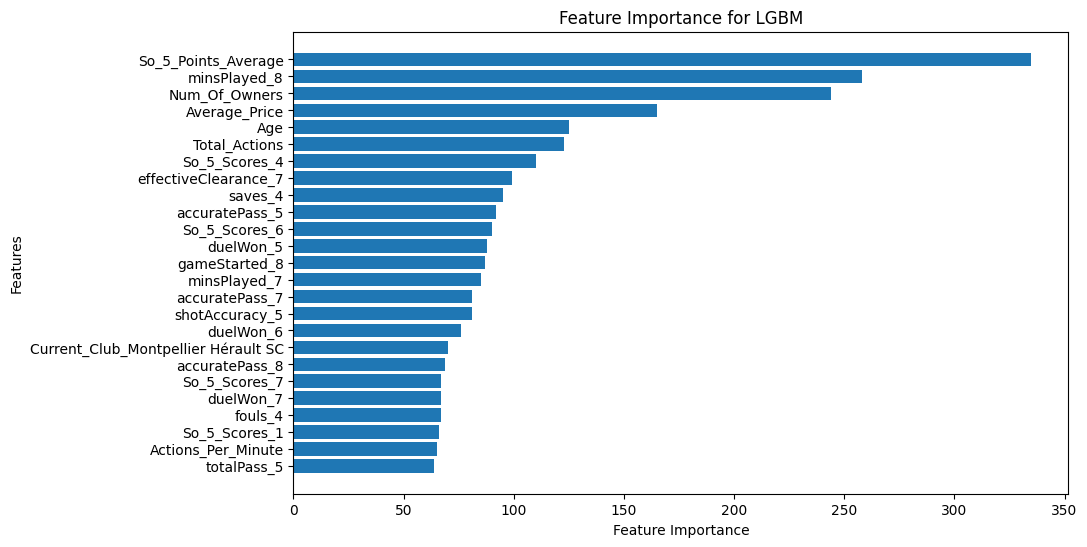

In [18]:
import matplotlib.pyplot as plt


# Get feature importances
importances = lgbm_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for LGBM')
plt.gca().invert_yaxis()
plt.show()